# Experimenting with lemmatization SVD/LSA

In this notebook I will attempt to reduce the high dimensional data created from tf-idf into a lower dimensional space using SVD. SVD stands for **Singular Value Decomposition**. It is used commonly in conjunction with tf-idf matrices to perform what is known as **Latent Semantic Analysis (LSA)**. Contrary to PCA, SVD will not center the data before reducing dimensions, which makes it work better with sparse matrices (exactly what we have).

Otherwise, this is exactly the same as LDA Topic modelling.

This dimensionality reduction can be performed using truncated SVD. SVD, or singular value decomposition, is a technique in linear algebra that factorizes any matrix M into the product of 3 separate matrices: 

$$M=U*S*V$$

Where S is a diagonal matrix of the singular values of M. Critically, truncated SVD reduces dimensionality by selecting only the t largest singular values, and only keeping the first t columns of U and V. In this case, t is a hyperparameter we can select and adjust to reflect the number of topics we want to find.

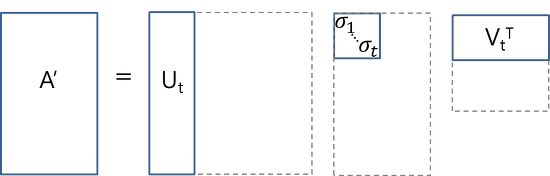

In [1]:
# from google.cloud import bigquery
import os
import json
import pandas as pd
import numpy as np
import re

In [2]:
# df = pd.read_csv("514_companies.csv")
# df
df = pd.read_json("bq_2018_top5SIC.json", lines = True)
df.head()

,accessionNumber,filingDate,reportingDate,financialEntity,htmlFile,coDescription,CIK,name,countryinc,cityma,SIC,SIC_desc
0,0001441816-18-000028,2018-03-30 20:12:23 UTC,2018-02-01,financialEntities/params;cik=1441816,https://www.sec.gov/Archives/edgar/data/144181...,Item 1. BusinessOverviewMongoDB is the leading...,1441816,"MONGODB, INC.",US,NEW YORK,7372,Prepackaged Software (mass reproduction of sof...
1,0001108524-18-000011,2018-03-09 22:01:46 UTC,2018-02-01,financialEntities/params;cik=1108524,https://www.sec.gov/Archives/edgar/data/110852...,ITEM 1. BUSINESSOverviewSalesforce is a global...,1108524,SALESFORCE COM INC,US,SAN FRANCISCO,7372,Prepackaged Software (mass reproduction of sof...
2,0001564590-18-006986,2018-03-28 21:27:30 UTC,2018-02-01,financialEntities/params;cik=1385867,https://www.sec.gov/Archives/edgar/data/138586...,"Item 1.Business1<p style=""margin-bottom:0pt;ma...",1385867,COUPA SOFTWARE INC,US,SAN MATEO,7372,Prepackaged Software (mass reproduction of sof...
3,0001353283-18-000004,2018-03-30 21:21:46 UTC,2018-02-01,financialEntities/params;cik=1353283,https://www.sec.gov/Archives/edgar/data/135328...,Item 1. BusinessOverviewSplunk provides innov...,1353283,SPLUNK INC,NaN,SAN FRANCISCO,7372,Prepackaged Software (mass reproduction of sof...
4,0001660134-18-000007,2018-03-12 20:45:43 UTC,2018-02-01,financialEntities/params;cik=1660134,https://www.sec.gov/Archives/edgar/data/166013...,Item 1. BusinessOverview Okta is the leading i...,1660134,"OKTA, INC.",US,SAN FRANCISCO,7372,Prepackaged Software (mass reproduction of sof...


In [3]:
#strip any left over html code

def clean_data_fn(insrt_data):
    
    clean_data = []
    
    for idx, ele in insrt_data.iterrows():
        if "https://www.sec.gov/Archives/edgar/data/" in ele["coDescription"]:
            pass
        else:
            clean_txt = re.compile('<.*?>')
            
#             pos = 0
#             if re.search('financialEntities/params;cik=', ele["financialEntity"]):
#                 # Extract the position of beginning of pattern
#                 pos = re.search('financialEntities/params;cik=', ele["financialEntity"]).end()
#             entity = ele["financialEntity"][pos:]
            
            desc = re.sub(clean_txt,'',ele["coDescription"]).replace(u'\xa0', u' ').replace("   ", "").replace("'", "").replace('"','')
            
            if re.search('<', desc):
                pos = re.search('<', desc).start()
            
            desc = desc[:pos].lower()
            
            if (desc.find("business") >= 20): # didnt find it in the first 20 characters then look for next
                desc = desc[6 : ( desc.rfind("<") )] # remove the "Item 1." stuff only

            else: # found "business", remove everything before it
                desc =  desc[( desc.find("business") + 8 ) : ( desc.rfind("<") ) ]
            
#             if (desc.find("BUSINESS") == -1): # didnt find it then look for next
#                 if(desc.find("Business") == -1): # didnt find it then just remove anything after "<" if at all
#                     desc = desc[6 : ( desc.rfind("<") )]

#                 else: # found "Business.", remove everything before it
#                     desc =  desc[( desc.find("Business") + 9 ) : ( desc.rfind("<") ) ]
#             else:
#                 desc = desc[( desc.find("BUSINESS") + 8 ) : ( desc.rfind("<") ) ]
            
            # remove leading white space and periods
            desc = re.sub(r"^\.", "", desc).strip()
                
            new_data = ele.copy()
            new_data["coDescription"] = desc
#             new_data = pd.Series([ele[0], entity, desc], index = insrt_data.columns)
            
            if len(desc)<250:
                pass
            else:
                clean_data.append(new_data)
    return(pd.DataFrame(clean_data))

non_html_data = clean_data_fn(df)#.rename(columns = {"financialEntity":"CIK"})
non_html_data["CIK"] = non_html_data["CIK"].astype(int)
non_html_data.head()

,accessionNumber,filingDate,reportingDate,financialEntity,htmlFile,coDescription,CIK,name,countryinc,cityma,SIC,SIC_desc
0,0001441816-18-000028,2018-03-30 20:12:23 UTC,2018-02-01,financialEntities/params;cik=1441816,https://www.sec.gov/Archives/edgar/data/144181...,"overviewmongodb is the leading modern, general...",1441816,"MONGODB, INC.",US,NEW YORK,7372,Prepackaged Software (mass reproduction of sof...
1,0001108524-18-000011,2018-03-09 22:01:46 UTC,2018-02-01,financialEntities/params;cik=1108524,https://www.sec.gov/Archives/edgar/data/110852...,overviewsalesforce is a global leader in custo...,1108524,SALESFORCE COM INC,US,SAN FRANCISCO,7372,Prepackaged Software (mass reproduction of sof...
3,0001353283-18-000004,2018-03-30 21:21:46 UTC,2018-02-01,financialEntities/params;cik=1353283,https://www.sec.gov/Archives/edgar/data/135328...,overviewsplunk provides innovative software so...,1353283,SPLUNK INC,NaN,SAN FRANCISCO,7372,Prepackaged Software (mass reproduction of sof...
4,0001660134-18-000007,2018-03-12 20:45:43 UTC,2018-02-01,financialEntities/params;cik=1660134,https://www.sec.gov/Archives/edgar/data/166013...,overview okta is the leading independent provi...,1660134,"OKTA, INC.",US,SAN FRANCISCO,7372,Prepackaged Software (mass reproduction of sof...
5,0001564590-18-007164,2018-03-29 21:34:05 UTC,2018-02-01,financialEntities/params;cik=1393052,https://www.sec.gov/Archives/edgar/data/139305...,overview veeva is a leading provider of indust...,1393052,VEEVA SYSTEMS INC,NaN,PLEASANTON,7372,Prepackaged Software (mass reproduction of sof...


In [28]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')

lemmatizer = WordNetLemmatizer()

def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:                    
        return None
    
def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))    
    wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
    res_words = []
    for word, tag in wn_tagged:
        if tag is None:                        
            res_words.append(word)
        elif tag.startswith('N'):
            res_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(res_words)

lemma_desc = non_html_data["coDescription"].apply(lemmatize_sentence)
non_html_data["coDescription_lemmatized"] = lemma_desc
non_html_data["coDescription_lemmatized"]

0       the , . our to and and across a of . can our a...
1       a in , or , . we our through the as a . we our...
3       that to by the of their . our to , , , , , and...
4       the of for the . our to any to any , and we th...
5       a of for the . we in 2007 on the that could ad...
                              ...                        
1114    on 19 , 2013 as a and to as a with our 31 , 20...
1115    the . our could from those in these as a of , ...
1117    and of of of , and to our and and with the of ...
1121    this : we as in the as the as of 31 , 2018 ( w...
1123    the , we , our , ours , us and the to , all in...
Name: coDescription_lemmatized, Length: 675, dtype: object

In [27]:
# non_html_data.to_csv("lemmatized.csv")

In [10]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# remove all numbers so they don't show up as dimensions
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

n_components = 12
pipe = Pipeline([('count', CountVectorizer(preprocessor=preprocess_text,
                                           ngram_range = (2,5),
                                           stop_words = 'english', max_features = 600)),
                 ('tfidf', TfidfTransformer())]).fit(non_html_data["coDescription_lemmatized"])
#                  ('svd', TruncatedSVD(n_components = n_components))]).fit(df["coDescription"])

In [14]:
tf_idf = pd.DataFrame(pipe.transform(non_html_data['coDescription_lemmatized']).toarray())
tf_idf

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.125073,0.030955,0.030955,0.135720,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.088678,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.067113,0.067113,0.000000,0.000000,0.000000,0.000000
2,0.0,0.000000,0.029512,0.000000,0.000000,0.065738,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.028987,0.028987,0.000000,0.000000,0.081883,0.043955
3,0.0,0.000000,0.000000,0.000000,0.000000,0.113926,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.067657,0.050234,0.050234,0.044050,0.000000,0.000000,0.000000
4,0.0,0.000000,0.006557,0.004734,0.004255,0.001826,0.012098,0.011707,0.000000,0.080678,...,0.039998,0.001736,0.001901,0.000000,0.000000,0.000000,0.153902,0.000000,0.013646,0.017091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,0.0,0.035027,0.000000,0.000000,0.000000,0.023926,0.019816,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.021100,0.021100,0.037004,0.041240,0.000000,0.000000
671,0.0,0.000000,0.000000,0.000000,0.000000,0.009966,0.008254,0.000000,0.013175,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.008789,0.008789,0.000000,0.000000,0.000000,0.000000
672,0.0,0.000000,0.000000,0.000000,0.008149,0.027973,0.005792,0.000000,0.000000,0.000000,...,0.067024,0.002216,0.002427,0.000000,0.000000,0.000000,0.156830,0.168756,0.011614,0.015586
673,0.0,0.106114,0.032540,0.000000,0.000000,0.000000,0.030016,0.046476,0.000000,0.068145,...,0.000000,0.000000,0.000000,0.000000,0.031961,0.031961,0.056053,0.062469,0.000000,0.000000


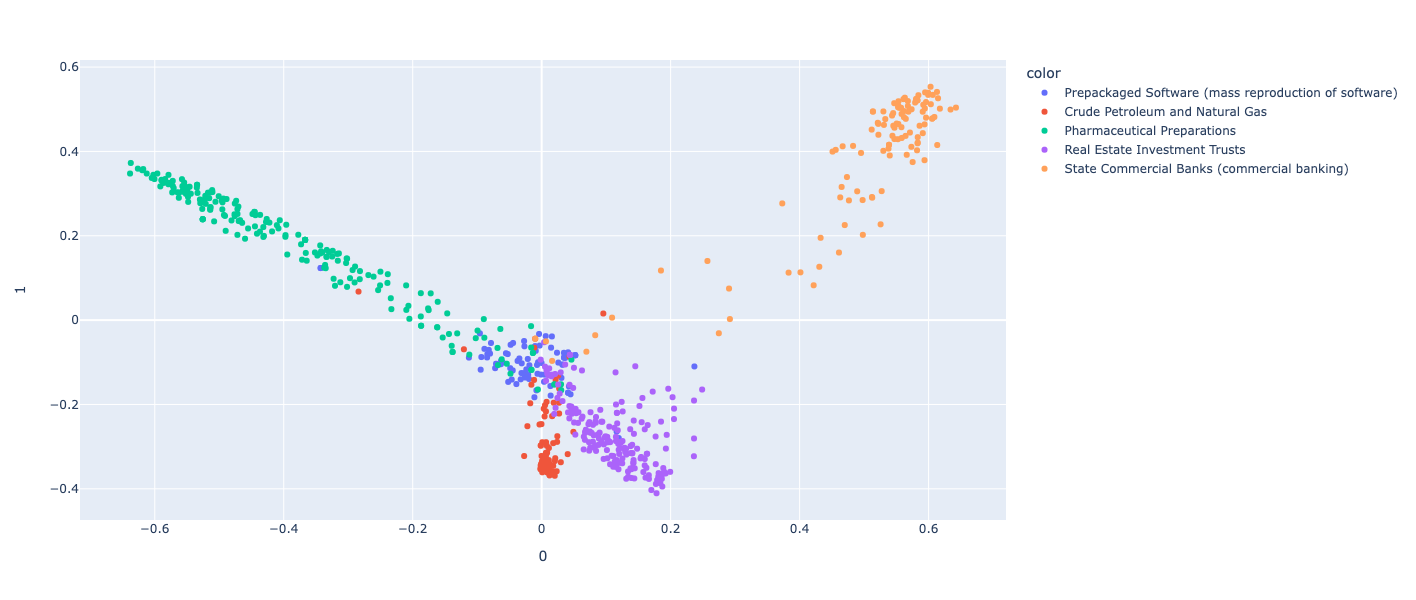

In [20]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px

# Referenced from my CSCD25 course
def visualize_pca(vectors, index):
    multi_index = pd.MultiIndex.from_frame(index, names=["name", "industry"])
    
    pca = PCA(n_components = n_components//2)
    pca_embedding = pca.fit_transform(vectors)
    pca_embedding = pd.DataFrame(pca_embedding, index = multi_index)
    
#     kmeans = KMeans(n_clusters = n_components).fit(vectors)
#     pca_embedding['cluster'] = kmeans.labels_
#     pca_embedding['cluster'] = index.iloc[:,1]
#     pca_embedding['cluster'] = pca_embedding['cluster'].astype('category')
    
    fig = px.scatter(pca_embedding, x =0 , y = 1, hover_data={"name": pca_embedding.index.get_level_values(0),
                                                              "industry": pca_embedding.index.get_level_values(1)},
                     color = pca_embedding.index.get_level_values(1), width=1200, height=600)
    fig.show()
    
    return [pca, pca_embedding]

plot_pca = visualize_pca(tf_idf, non_html_data.loc[:,["name","SIC_desc"]])


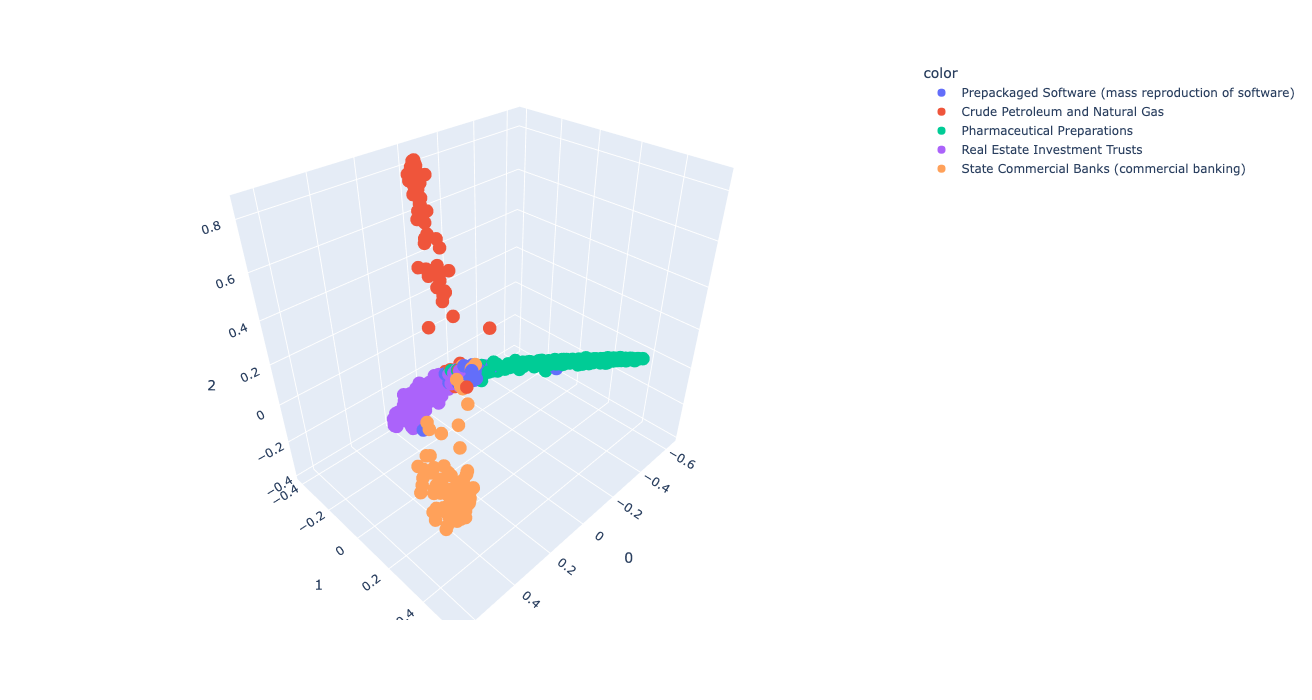

In [21]:
fig = px.scatter_3d(plot_pca[1], x =0 , y = 1, z = 2, hover_data={"name": plot_pca[1].index.get_level_values(0),
                                                              "industry": plot_pca[1].index.get_level_values(1)},
                    color = plot_pca[1].index.get_level_values(1), width=1200, height=700)
fig.show()

In [17]:
# From the explained variance ratio, we see that the top three dimensions don't actually explain that much of the variation that exists within our data/companies.
plot_pca[0].explained_variance_ratio_

array([0.12064164, 0.09048224, 0.06986419, 0.03625567, 0.0198122 ,
       0.0191517 ])

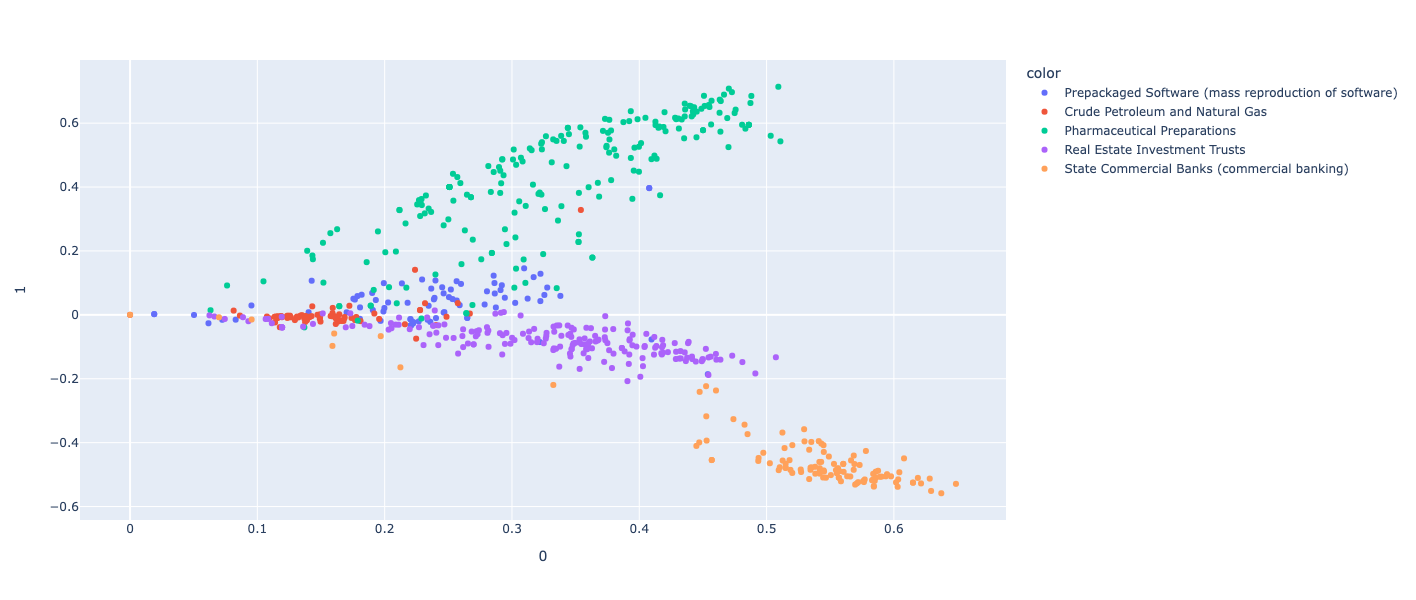

In [23]:
from sklearn.decomposition import TruncatedSVD
def visualize_svd(vectors, index):
    multi_index = pd.MultiIndex.from_frame(index, names=["name", "industry"])
    
    svd = TruncatedSVD(n_components = n_components//2)
    svd_embedding = svd.fit_transform(vectors)
    svd_embedding = pd.DataFrame(svd_embedding, index = multi_index)
    
#     kmeans = KMeans(n_clusters = n_components).fit(vectors)
#     pca_embedding['cluster'] = kmeans.labels_
#     pca_embedding['cluster'] = index.iloc[:,1]
#     pca_embedding['cluster'] = pca_embedding['cluster'].astype('category')
    
    fig = px.scatter(svd_embedding, x =0 , y = 1, hover_data={"name": svd_embedding.index.get_level_values(0),
                                                              "industry": svd_embedding.index.get_level_values(1)},
                     color = svd_embedding.index.get_level_values(1), width=1200, height=600)
    fig.show()
    
    return [svd, svd_embedding]

plot_svd = visualize_svd(tf_idf, non_html_data.loc[:,["name","SIC_desc"]])


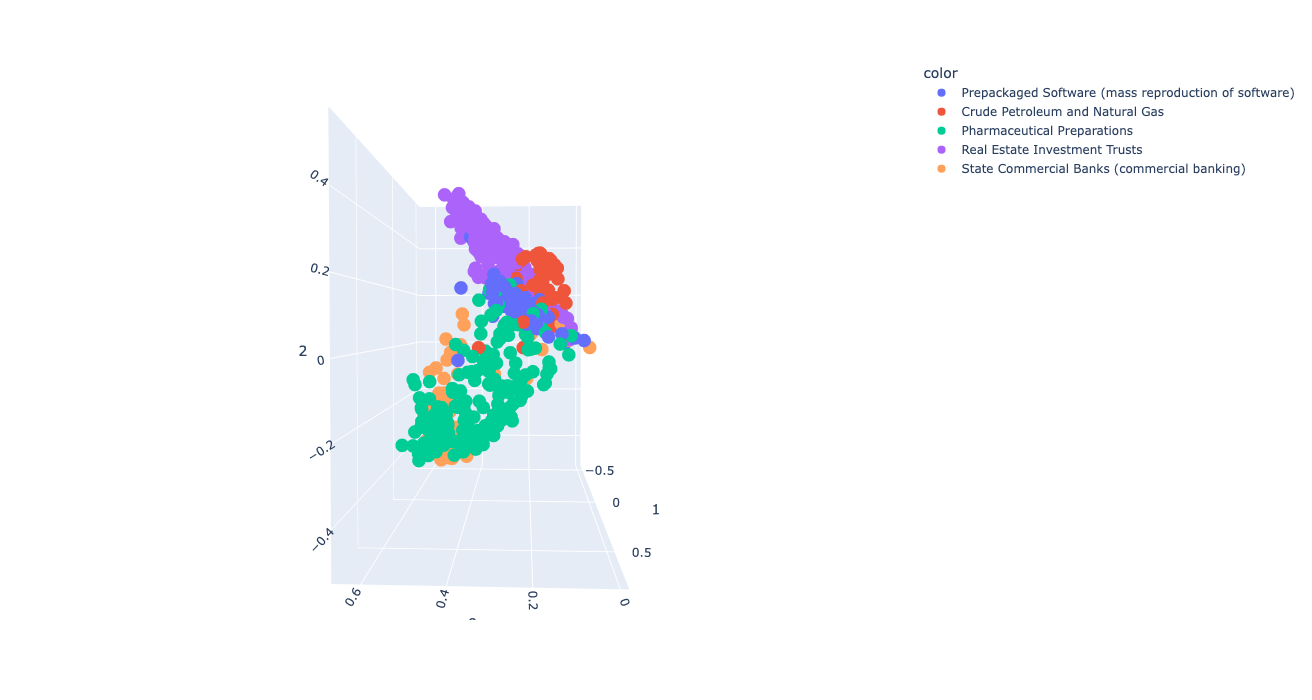

In [24]:
fig = px.scatter_3d(plot_svd[1], x =0 , y = 1, z = 2, hover_data={"name": plot_svd[1].index.get_level_values(0),
                                                              "industry": plot_svd[1].index.get_level_values(1)},
                    color = plot_svd[1].index.get_level_values(1), width=1200, height=700)
fig.show()

In [26]:
# From the explained variance ratio, we see that the top three dimensions don't actually explain that much of the variation that exists within our data/companies.
plot_svd[0].explained_variance_ratio_

array([0.02244332, 0.11867035, 0.08416785, 0.06647414, 0.03429402,
       0.01915673])